# Machine Learning and Prediction of Disposal Outlet by Waste Description

This test case uses data relating to hazardous chemical waste and attempts to determine the fate, or disposal outlet / waste company that can move the waste towards it's final end point. The problem is that of choosing which of many disposal outlets would be most suitable, i.e. it is a multiclassification exercise. The data is sourced from records of succesfull waste transactions and includes a general description, chemical components, various hazardous classification descriptors and a disposal outlet. 

Having some considerable experience with the data set beforehand there are a few points to raise before we go exploring. The data source is from an very old database (c.1985) and data input has largely been via free text entry fields, made by a many different users over a period of about 15 years. The quality and consistency of the result is extremely poor. 

There are many opportunities for standardised terms but with no drop down menu options and no input validation we find that various phrases have been used for the same thing. The few standardised terms take the form of code numbers, i.e. they are a string of number characters but represent categorical rather than scalar values. Also because of their origin in Excel these numbers are sometimes preceded with an apostophe, used to force Excel to treat number characters as text. All descriptors can be divided even further when we add the many more variations created by typos and spelling mistakes. 

As a human consumer the descriptors provided form a common meaning which when interogated on a one by one basis provide a useful data record, however when considering more than one record using an automated approach the similarity of meaning or semantics is considerably more difficult. To this end some inspiration has come from studies involving the multiclassification of semantics, in the form of food and wine reviews. [1]

The approach in this reference relates to the similarity of meaning in a variety of diverse terms, i.e. natural language, a word processor Word2Vec is trained on a very large corpus of natural language terms. In our case the vocabulary is very limited, there are many acronyms, the language is rich in chemical names and specialised technical terms. Word embedding, vectorisation can be achieved using a far reduced corpus [2].

After first of all, exploring the data, and perparing a preprosessing pipeline, a comparison is made between RandomForestClassifier and XGBoostClassifier, both popular approaches to classification problems.

Inspriation for this approach came from: 
1. https://github.com/JungeAlexander/kaggle-amazon-fine-food-reviews
2. https://www.geeksforgeeks.org/python-word-embedding-using-word2vec/



# Data Exploration

As we explore each section of the data we will do some rudimentary analysis, build and test a segment of the pipe and visualise the result. 

Import a few libraries

In [5]:
import pandas as pd                                        # Used for importing data and transformations
import numpy as np                                         # Provides mathmatical functions and randomisers
import matplotlib.pyplot as plt                            # Plot charts
import seaborn as sn                                       # Visualisation tools
import warnings                                            # Manage python system warnings
warnings.simplefilter('ignore')
sn.color_palette("flare", as_cmap=True)
from nltk.tokenize import word_tokenize
import nltk as nltk
import string

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import FeatureHasher 
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


### Constants

In [6]:
# A list of all legitimate values in the Hazard Codes column
hp_codes = ['HP1','HP2','HP3','HP4','HP5','HP6','HP7','HP8','HP9','HP10','HP11','HP12','HP13','HP14','HP15', 'NC','POP']

# A list of all legitimate values in the Physical State column
physical_states = ['SOLID','SLUDGE','LIQUID','GAS','MIXED','POWDER']

# The minimum number of occurances of each class is governed by the number of data folds for stratification and cross validation 
# and a whole number multiplier.
k_folds = 5

# A multiplier for k_folds.
num_k_folds = 1

Import the data and preliminay look at the shape and data types.

In [7]:
df = pd.read_csv("data/raw3.csv")
print(f'The primary data set has {len(df.columns)} columns and {len(df)} rows.')
print('Data types:')
print(df.dtypes.value_counts())
df.head(2)

The primary data set has 42 columns and 21046 rows.
Data types:
object     40
float64     2
dtype: int64


,DRUM ID,QTY,Cont. Size,Quantity (Kg),Description,Components and Concentrations,Hazard Codes,UN Number,Proper Shipping Name,Class,...,24-26 Weeks,>6 Months,Origin District,Destination District,Date Out,DR Code,Tonnage,Municipal Source,Column1,EWC2
0,NaN,80,60,1.5,EMPTY PLASTIC DRUMS (60L),NIL HAZARDOUS COMPONENTS,N/C,NCAD,NOT CLASSIFIED AS DANGEROUS FOR TRANSPORT,N/C,...,0,0,SHEFFIELD,LEEDS,11/01/2023,R03 - RECYCLING OF ORGANIC SUBSTANCES,0.0015,No,R03 - Recycling of organic substances,150110
1,NaN,4,30,2.0,EMPTY PLASTIC DRUMS (30L),Nil hazardous components,N/C,NCAD,NOT CLASSIFIED AS DANGEROUS FOR TRANSPORT,N/C,...,0,0,SHEFFIELD,LEEDS,11/01/2023,R03 - RECYCLING OF ORGANIC SUBSTANCES,0.002,No,R03 - Recycling of organic substances,150110


In [8]:
# A helper function for visualisation
def create_histogram_from_column(dataframe, column_name, width, height):
    plt.figure(figsize=(width, height))
    dataframe[column_name].value_counts().plot(kind='bar', color='skyblue')
    plt.title(f'Histogram of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.show()

The classifier that we are trying to predict is the disposal outlet.

The usage distribution of each of the 47 outlets:
WASTECARE NORMANTON         2669
RED INDUSTRIES              1942
FCC BBM                     1857
CLEAN PAK                   1710
ROBERT HOPKINS              1657
MALARY                      1439
MYTUM MALTINGS               958
VEOLIA NORWOOD               864
VEOLIA ELLESMERE PORT        657
SWARF                        654
MULBERRY                     639
BURSCOUGH                    491
CASTLE                       460
WEDNESBURY                   448
LOUGHBOROUGH                 424
AVANTI                       404
ERP                          374
TRADEBE FAWLEY               358
OIL RECOVERIES               351
PACKCARE                     311
ECO BAT                      290
MULBERRY KNOWSLEY            286
SLICKER                      235
FCC ECCLESFIELD              222
FCC KNOSTROP                 176
ATTLEBOROUGH                 164
ESYNERGY                     155
FUTURE                       108
MYTUM SHERBURN            

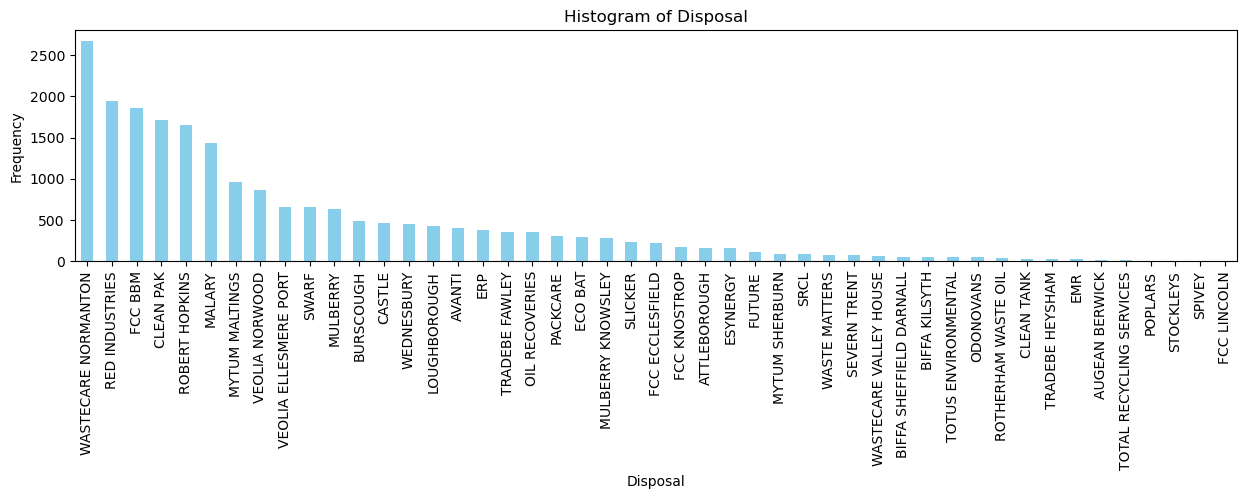

In [9]:
# Find the unique values for Disposal and arrange alphabetically
outlets = pd.DataFrame({'Disposal': df['Disposal'].unique()})
outlets = outlets.sort_values(by='Disposal').reset_index(drop=True)

print(f'The usage distribution of each of the {len(outlets)} outlets:')

# Remove any rows with empty disposal columns
df.dropna(subset=['Disposal'], inplace=True)

# Count occurrences of each label
label_counts = df['Disposal'].value_counts()
print(label_counts)

# Add a visualisation
create_histogram_from_column(df, 'Disposal', 15, 3)

Disposal outlets that only appear a few times in our dataset don't offer sufficient information for training purposes. We will be performing cross validation at a later stage and comparing different folds in the data, we will need to ensure that each class is equally represented in across all folds so the number of folds becomes a limiting factor and to equally represent each class will entail that the miniumum number of occurances must be a mutliple of the number of folds. In this case we are using k_folds and a multiplier of num_k_folds to determine the minimum frequency.

RowTrimmer is an estimator that will remove the disposal outlets with the lowest frequency.

## Preprocessing

These are general tidying, cleansing and repairing activities prior to any splitting of data.

### Row Trimmer

In [10]:
# Create a Row Trimmer by extending the BaseEstimator class
class RowTrimmer(BaseEstimator, TransformerMixin):
    def __init__(self, min_count=5):
        self.min_count = min_count

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        before_trim_size = len(X)

        # Drop rows with nothing in the Disposal Column
        X.dropna(subset=['Disposal'], inplace=True)
        label_counts = X['Disposal'].value_counts()
        
        # Find the indices of labels that appear less than min_count times.
        unique_labels = label_counts[label_counts < self.min_count].index

        # Using the index value, filter out rows where the label appears only once.
        X = X[~X['Disposal'].isin(unique_labels)]

        # Reset row indexing
        X = X.reset_index(drop=True)
        after_trim_size = len(X)

        # After trimming rows that we don't want, reset outlets.
        outlets = pd.DataFrame({'Disposal': df['Disposal'].unique()})
        outlets = outlets.sort_values(by='Disposal').reset_index(drop=True)

        print(f'RowTrimmer: Out of {len(label_counts)} outlets, {len(unique_labels)} appear less than { self.min_count} times. {before_trim_size - after_trim_size} rows have been trimmed.')
        print(f'RowTrimmer: {X.shape}')
        return X

Testing RowTrimmer

In [11]:
# Test RowTrimmer
from sklearn.pipeline import Pipeline
rt_params = {
    'rt__min_count': k_folds * num_k_folds
}

# Create a pipeline to build a model
rt_pipe = Pipeline([
    ('rt', RowTrimmer())
])

rt_pipe.set_params(**rt_params)

# Example usage of the pipeline
rt_trim = rt_pipe.fit_transform(df)

RowTrimmer: Out of 47 outlets, 2 appear less than 5 times. 3 rows have been trimmed.
RowTrimmer: (21043, 42)


Having trimmed away a few unhelpful rows, we can now consider columns. Of the 42 or so columns, there are only a few that can be used as descriptors and a second data file labels.xlsx, is provided that lists all columns and indicates which ones are useful.

ColumnTrimmer estimator will tidy up the labels.xlsx file and use the values to produce a trimmed dataframe that contains only features of interest.

### Column Trimmer

In [12]:
# Define the ColumnTrimmer class
class ColumnTrimmer(BaseEstimator, TransformerMixin):
    def __init__(self, filename=''):
        self.filename = filename

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Load the excel file
        lb = pd.read_excel(self.filename, header=0)
        lb.head(2)

        # Fill in any missing values in the In/Out column.
        lb.fillna("OUT", inplace=True)

        # Replace any values that are not either IN or OUT.
        temp = [value if value in ["IN", "OUT"] else "OUT" for value in lb['In/Out'].values] 
        lb['In/Out'] = temp

        # Filter the labels for those where In/Out == IN
        features = lb[lb['In/Out']=='IN'].astype('str')
        self.columns_to_keep = [col.strip() for col in features['Column'].values]
        #self.columns_to_keep = [col.strip().replace(' ', '_') for col in features['Column'].values]

        # Select only specified columns
        if self.columns_to_keep is not None and any(self.columns_to_keep):
            transformed_df = X[self.columns_to_keep]  
        else:
            transformed_df = X
        
        print(f'ColumnTrimmer: After trimming {len(transformed_df.columns)} columns remain.')
        print(f'{transformed_df.dtypes}')
        print(f'ColumnTrimmer: {transformed_df.shape}')
        return transformed_df

Testing ColumnTrimmer

In [13]:
# Redefine params
ct_params = {
    'ct__filename': 'data/labels.xlsx'
}

# Create a pipeline to build a model
ct_pipe = Pipeline([
    ('ct', ColumnTrimmer())
])

ct_pipe.set_params(**ct_params)

# Re-run the pipeline with new estimators
ct_trim = ct_pipe.fit_transform(rt_trim)
ct_trim.tail(5)

ColumnTrimmer: After trimming 7 columns remain.
Description                      object
Components and Concentrations    object
Hazard Codes                     object
UN Number                        object
EWC                              object
Disposal                         object
Physical State                   object
dtype: object
ColumnTrimmer: (21043, 7)


,Description,Components and Concentrations,Hazard Codes,UN Number,EWC,Disposal,Physical State
21038,WATER BASED PAN WASH CLEANING SLURY,non hazardous paint-<10%/water-balance,N/C,NCAD,80120,FCC KNOSTROP,SLUDGE
21039,WATER BASED PAN WASH CLEANING SLURY,non hazardous paint-<10%/water-balance,N/C,NCAD,80120,FCC KNOSTROP,SLUDGE
21040,WATER BASED PAN WASH CLEANING SLURY,non hazardous paint-<10%/water-balance,N/C,NCAD,80120,FCC KNOSTROP,SLUDGE
21041,SCRAP METAL,NIL HAZARDOUS COMPONENTS,None,NCAD,200140,EMR,SOLID
21042,EMPTY CONTAINERS LOAD,AMMONIUM THIOSULPHATE-=<4%/SODIUM SULPHITE-=<1...,HP4,NCAD,150110*,STOCKLEYS,SOLID


### ReplaceEmptyCellsTransformer

After trimming unecessary columns and rows we can then move on to reparing a few holes.

In [14]:
print(ct_trim.isnull().sum())

Description                        0
Components and Concentrations    622
Hazard Codes                       5
UN Number                          2
EWC                                0
Disposal                           0
Physical State                     0
dtype: int64


ReplaceEmptyCellsTransformer will accept a dictionary of default values, indexed by the feature name and fill in any null values with an appropriate value. There are possibly other ways to approach this, for example use an imputer and fill in with the most frequent value, or for numbers the average value.

In [15]:
class ReplaceEmptyCellsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, replace_values=None):
        self.replace_values = replace_values

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for col, val in self.replace_values.items():            
            X[col].fillna(val, inplace=True)
        return X


Testing ReplaceEmptyCellsTransformer

In [16]:
# A dictionary of default values used for completing missing values.
replace_values = {
    'Components and Concentrations':'As List',
    'Hazard Codes':'NC',
    'UN Number':'NCAD'
}

# Redefine params
rv_params = {
    'rv__replace_values': replace_values
}

# Create a pipeline to build a model
rv_pipe = Pipeline([
    ('rv', ReplaceEmptyCellsTransformer())
])

rv_pipe.set_params(**rv_params)

# Re-run the pipeline with new estimators
rv_trim = rv_pipe.fit_transform(ct_trim)
print(rv_trim.isnull().sum())
rv_trim.tail(5)

Description                      0
Components and Concentrations    0
Hazard Codes                     0
UN Number                        0
EWC                              0
Disposal                         0
Physical State                   0
dtype: int64


,Description,Components and Concentrations,Hazard Codes,UN Number,EWC,Disposal,Physical State
21038,WATER BASED PAN WASH CLEANING SLURY,non hazardous paint-<10%/water-balance,N/C,NCAD,80120,FCC KNOSTROP,SLUDGE
21039,WATER BASED PAN WASH CLEANING SLURY,non hazardous paint-<10%/water-balance,N/C,NCAD,80120,FCC KNOSTROP,SLUDGE
21040,WATER BASED PAN WASH CLEANING SLURY,non hazardous paint-<10%/water-balance,N/C,NCAD,80120,FCC KNOSTROP,SLUDGE
21041,SCRAP METAL,NIL HAZARDOUS COMPONENTS,None,NCAD,200140,EMR,SOLID
21042,EMPTY CONTAINERS LOAD,AMMONIUM THIOSULPHATE-=<4%/SODIUM SULPHITE-=<1...,HP4,NCAD,150110*,STOCKLEYS,SOLID


### Text Cleaner

In [17]:
class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self,  remove_number_cols=None):
        self.remove_number_cols = remove_number_cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X): 
        col = ''   
        cols = []
        text = ''
        try:                        
            for col in X.columns:
                cols.append(col)  
                cleaned_text = []
                for text in X[col]:  
                    # For Hazard Codes only
                    if col=='Hazard Codes':
                        if text=='':
                            text = 'NC'
                        if text=='None':
                            text = 'NC'                  
                    if text is not None and not pd.isna(text):
                        try:
                            # Remove whitespaces from either end
                            text = text.strip()
                        except:
                            print(f'Text failed for strip method {text}')
                        
                        # Remove punctuation
                        text = ''.join([c if c not in string.punctuation else ' ' for c in text])

                        # Remove numbers
                        if col in self.remove_number_cols:
                            text = ''.join([char if not char.isdigit() else ' ' for char in text])

                        # For EWC Codes only, length must be 6
                        if col=='EWC':
                            if len(text)==5:
                                text = '0' + text
                        
                        # Tokenize the text
                        words = word_tokenize(text)

                        # Remove single letters
                        words = [word for word in words if len(word) > 1]

                        # Collect words
                        cleaned_text.append(' '.join(words))
                            
                    else:
                        #cleaned_text.append(' '.join(''))
                        print('')
                X[col] = cleaned_text
                
        except Exception as e:
            print(f"TextCleaner: An error occurred transforming text in {col}: {text}:", e)
        else:
            # Code to execute if no exception is raised
            print(f"TextCleaner: Successfully completed: {cols}")
        finally:
            print(f'TextCleaner: Finished Shape: {X.shape}')
            print('-'*100) 
        return X

Testing TextCleaner

In [18]:
# Redefine params
tc_params = {
    'tc__remove_number_cols': ['Description', 'Components and Concentrations']
}

# Create a pipeline to build a model
tc_pipe = Pipeline([
    ('tc', TextCleaner())
])

tc_pipe.set_params(**tc_params)

# Re-run the pipeline with new estimators
tc_trim = tc_pipe.fit_transform(rv_trim)
tc_trim.tail(5)

TextCleaner: Successfully completed: ['Description', 'Components and Concentrations', 'Hazard Codes', 'UN Number', 'EWC', 'Disposal', 'Physical State']
TextCleaner: Finished Shape: (21043, 7)
----------------------------------------------------------------------------------------------------


,Description,Components and Concentrations,Hazard Codes,UN Number,EWC,Disposal,Physical State
21038,WATER BASED PAN WASH CLEANING SLURY,non hazardous paint water balance,,NCAD,080120,FCC KNOSTROP,SLUDGE
21039,WATER BASED PAN WASH CLEANING SLURY,non hazardous paint water balance,,NCAD,080120,FCC KNOSTROP,SLUDGE
21040,WATER BASED PAN WASH CLEANING SLURY,non hazardous paint water balance,,NCAD,080120,FCC KNOSTROP,SLUDGE
21041,SCRAP METAL,NIL HAZARDOUS COMPONENTS,NC,NCAD,200140,EMR,SOLID
21042,EMPTY CONTAINERS LOAD,AMMONIUM THIOSULPHATE SODIUM SULPHITE ACETIC A...,HP4,NCAD,150110,STOCKLEYS,SOLID


## Model Building

We see that all columns are object data types, for machine learning we need to convert these from objects into either float, int or bool data types. On further review we have a combination of categorical data expressed as text, plus entirely free text that is rich in common words or phrases. Two of the categorical terms have very high numbers of possibilities (or dimensions).

Text based class labels:
- Disposal

Low Dimensional, Single Categorical terms:
- Physical State

Low Dimensional, Multi Categorical, space delimited terms:
- Hazard Codes

High Dimensional Categorical terms:
- EWC
- UN Number

Text columns:
- Description
- Components and Concentrations


### Approach
- Text based labels can be treated simply by adding an index column. See IndexTransformer.
- Low dimensional categorical terms can be encoded by one hot encoding. See OneHotTransformer
- Low dimensional categorical terms that need to be tokenised before one hot encoding. See OneHotTokenTransformer.
- High dimensional categorical terms would be best suited to feature hashing. See FeatureHashingTransformer.
- Text based columns can be cleansed and simplified by removing numbers, punctuation symbols and single letters, see TextCleaner.
- The CountVectorizer library can be used to turn text into a bag of words, with frequency counts. See ColumnVectoriser.

### Index Transformer

In [19]:
# Create a class for transforming a column of values into a column of index numbers of those values in a list of unique values
class IndexTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name=''):
        #if(column_name is not None):
        self.column_name = column_name        
        self.index_name = self.column_name + '_Index'

    def fit(self, X, y=None):
        self.index_name = self.column_name + '_Index'
        return self

    def transform(self, X):
        index_map = {}
        try:
            print(f'IndexTransformer Start: Unique Values: {len(X[self.column_name].unique())}' )
            # Tidy up a bit
            X[self.column_name].str.upper()
            X[self.column_name].str.strip()

            # Find the unique values and arrange alphabetically
            df_temp = pd.DataFrame({self.column_name: X[self.column_name].unique()})
            df_temp = df_temp.sort_values(by=self.column_name).reset_index(drop=True)

            # Create a dictionary mapping values to their index
            index_map = {item: idx for idx, item in enumerate(df_temp[self.column_name])}
                            
            # Find the index of each value in the list of unique values
            indices = [index_map[value] for value in X[self.column_name]]

            # Create a new column name +'_Index' in the DataFrame
            X[self.index_name] = indices

            # Remove the encoded column
            #X = X.drop(self.column_name, axis=1)
            
        except Exception as e:
            # Handle any other exceptions
            print(f"IndexTransformer: An error occurred in {self.column_name}:", e)
        else:
            # Code to execute if no exception is raised
            print(f"IndexTransformer: Successfully completed: {self.index_name}.")
        finally:
            print(f'IndexTransformer: Finished: Unique Values: {len(X[self.index_name].unique())}' )
            print('-'*100)  
        return X

### One Hot Transformer

In [20]:
# An estimator for Ono Hot Encoding
class OneHotTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name=None):
        self.column_name = column_name

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        transformed_data = pd.DataFrame()
        print(f'OneHotTransformer Start: {X.shape}')
        try:
            # Tidy up a bit
            X[self.column_name].str.upper()
            X[self.column_name].str.strip()

            # Small modifier for Physical State
            if(self.column_name=='Physical State'):
                X[self.column_name] = X[self.column_name].fillna('MIXED')
            
            # Create a copy of the data to encode
            df_temp = pd.DataFrame({'temp': X[self.column_name].values})

            # Call pandas get_dummies to one hot encode
            df_temp = pd.get_dummies(df_temp, prefix=self.column_name)
            #df_temp.reset_index(drop=True, inplace=True)

            # Remove the encoded column
            if self.column_name in X.columns:
                X = X.drop(self.column_name, axis=1)
                X.reset_index(drop=True, inplace=True)

            # Add columns to the model
            X = pd.concat([X, df_temp], axis=1)
            #X.reset_index(drop=True, inplace=True)
            
        except Exception as e:
            # Handle any other exceptions
            print(f"OneHotTransformer: An error occurred in {self.column_name}:", e)
        else:
            # Code to execute if no exception is raised
            print(f"OneHotTransformer: Successfully completed: {self.column_name}")
        finally:
            print(f'OneHotTransformer: Finished {self.column_name} Shape: {X.shape}')
            print('-'*100) 
        return X

### One Hot Token Transformer

In [21]:
# Anestimator for encoding strings of tokenised categories
class OneHotTokenTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name=None, tokens=None):
        self.column_name = column_name
        self.tokens = tokens

    def fit(self, X, y=None):
        # Fill missing values (NaN) in the 'Hazard_Codes' column with an empty string
        if(self.column_name=='Hazard Codes'):
            X[self.column_name].fillna('NC', inplace=True)

        # Small modifier for Physical State
        if(self.column_name=='Physical State'):
            X[self.column_name] = X[self.column_name].fillna('MIXED')
        return self

    def transform(self, X):
        transformed_data = pd.DataFrame()
        print(f'OneHotTokenTransformer Start: {X.shape}')
        try:
            # Tidy up a bit
            X[self.column_name].str.upper()
            X[self.column_name].str.strip()

            for hc in self.tokens:
                if hc not in X.columns:
                    X[hc] = 0

            # Split the codes in the 'Hazard_Codes' column and assign 1's and 0's
            for code in self.tokens:
                X[code] = X[self.column_name].apply(lambda x: 1 if code in x.split() else 0)
            
            # Remove the encoded column
            if self.column_name in X.columns:
                X = X.drop(self.column_name, axis=1)
                #X.reset_index(drop=True, inplace=True)
                        
        except Exception as e:
            # Handle any other exceptions
            print("OneHotTokenTransformer: An error occurred:", e)
        else:
            # Code to execute if no exception is raised
            print(f"OneHotTokenTransformer: Successfully completed: {self.column_name}")
        finally:
            # Code that will always run, regardless of an exception
            print(f'OneHotTokenTransformer: Finished {self.column_name} Shape: {X.shape}') 
            print('-'*100)       
        return X

### Feature Hashing Transformer

In [22]:
# An estimator for cleaning text and encoding with feature hashing.
class FeatureHashingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name=None, num_vec=6):
        self.column_name = column_name
        self.num_vec = num_vec

    def fit(self, X, y=None):
        if(self.column_name=='UN Number'):
            X[self.column_name].fillna('NCAD', inplace=True)
        return self
    
    def transform(self, X):
        print(f'FeatureHashingTransformer Start: {X.shape}')
        try:
            # A helper function for encoding highly diverse categorical information.
            def feature_hasher(data, prefix, num_features):
                # Initialize the FeatureHasher object
                hasher = FeatureHasher(n_features=num_features, input_type='string')

                # Apply feature hashing to the data
                hashed_features = hasher.transform(data.astype(str))

                # Shift the negative hashed features to make them positive
                hashed_features.data += abs(hashed_features.min())

                # Convert the hashed features to a DataFrame
                df_hashed = pd.DataFrame(hashed_features.toarray())

                # Add a prefix to the column name for each feature
                df_hashed.columns = [prefix + '_' + col for col in df_hashed.columns.astype('str')]            
                return df_hashed
                        
            # Tidy up a bit
            X[self.column_name] = X[self.column_name].str.upper()

            # Remove any preceding aphotrophes
            X[self.column_name] = X[self.column_name].str.lstrip("'")

            # Remove any following asterisks
            X[self.column_name] = X[self.column_name].str.rstrip("*")

            # Remove any whitespaces
            X[self.column_name] = X[self.column_name].str.strip()

            # Hash values into a dataframe
            df_fh = feature_hasher(X[self.column_name], self.column_name, self.num_vec)

            # Remove the encoded column
            X = X.drop(self.column_name, axis=1)
            X.reset_index(drop=True, inplace=True)
            
            # Add columns to the model
            X = pd.concat([X, df_fh], axis=1)
            #X.reset_index(drop=True, inplace=True)
            
        except Exception as e:
            # Handle any other exceptions
            print(f"FeatureHashingTransformer: An error occurred in {self.column_name}:", e)
        else:
            # Code to execute if no exception is raised
            print(f"FeatureHashingTransformer: Successfully completed: {self.column_name}")
        finally:
            print(f'FeatureHashingTransformer: Finished {self.column_name} Shape: {X.shape}')
            print('-'*100) 
        return X

### Column Vectoriser

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack

# Custom transformer to apply text preprocessing, remove numbers and punctuation, and then apply CountVectorizer
class ColumnVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, max_features_list=None):
        self.max_features_list = max_features_list
        self.vectorizers = {}
        self.stop_words = nltk.corpus.stopwords.words('english')
        # Additional terms specific to this application can be added, by extending the english stopwords set.
        new_stop_words = ['waste','contaminated','with','haz','hazardous','non','non-haz','non-hazardous','w/l','c/w','sched','scheduled','as','per']
        self.stop_words.extend(new_stop_words)

    def fit(self, X, y=None):
        self.vectorizers = {}
        for col, max_features in self.max_features_list.items():              
            vectorizer = CountVectorizer(max_features=max_features, stop_words=self.stop_words, min_df=0)
            vectorizer.fit(X[col])
            self.vectorizers[col] = vectorizer
        return self

    def transform(self, X):
        transformed_texts = []
        result = None
        try:
            for col, max_features in self.max_features_list.items():
                vectorizer = self.vectorizers[col]
                vectorized_text = vectorizer.transform(X[col])
                transformed_texts.append(vectorized_text)
            result = hstack(transformed_texts)
        except Exception as e:
            print(f"ColumnVectoriser: An error occurred vectorising text in {col}. ", e)
        else:
            # Code to execute if no exception is raised
            print(f"ColumnVectoriser: Successfully completed: {col}")
        finally:
            #print(f'ColumnVectoriser: Finished Shape: {X.shape}')
            print('-'*100) 
        return result


## EWC (European Waste Code)

These are categorical terms for the instustry sector from where the waste originates, they take the form of three pairs of number characters plus optionally an asterisk, most commonly the three pairs are joined to form a six digit number. Each disposal site has a list of allowable EWC codes on it's permit, this if anything should be the most significant term, however we do not have a copy of all of the sites permits. More than one site can have the same EWC so there are other factors to consider, not listed here such as comparative cost and geographical distance.

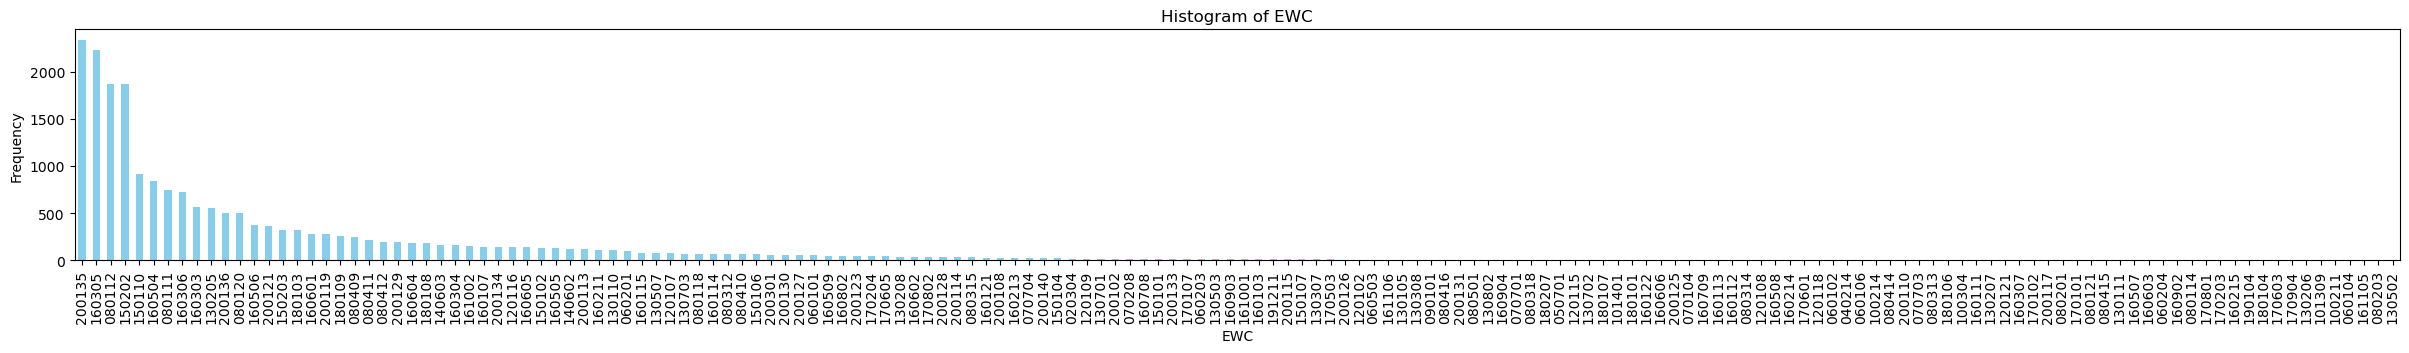

In [24]:
# Add a visualisation
create_histogram_from_column(rv_trim, 'EWC', 30, 3)

In [25]:
# Number of columns to use for EWC encoding
ewc_num_vec = 6

# Define parameters
ewc_params = {
    'et__column_name': 'EWC',
    'et__num_vec': ewc_num_vec
}

# Create a pipeline to build a model
ewc_pipe = Pipeline([
    ('et', FeatureHashingTransformer())
])

ewc_pipe.set_params(**ewc_params)

# Re-run the pipeline with new estimators
ewc_trim = ewc_pipe.fit_transform(ct_trim)
print(ewc_trim.iloc[:, -1 * ewc_num_vec:].head(2))

FeatureHashingTransformer Start: (21043, 7)
FeatureHashingTransformer: Successfully completed: EWC
FeatureHashingTransformer: Finished EWC Shape: (21043, 12)
----------------------------------------------------------------------------------------------------
   EWC_0  EWC_1  EWC_2  EWC_3  EWC_4  EWC_5
0    6.0    0.0    0.0    0.0    0.0    0.0
1    6.0    0.0    0.0    0.0    0.0    0.0


## Physical Form

A text field with categorical single word terms, since they are free text entry we should take a closer look.

There are 6 different forms: ['SOLID' 'LIQUID' 'MIXED' 'SLUDGE' 'GAS' 'POWDER']
SOLID     9239
MIXED     6544
LIQUID    3987
SLUDGE     951
GAS        265
POWDER      57
Name: Physical State, dtype: int64


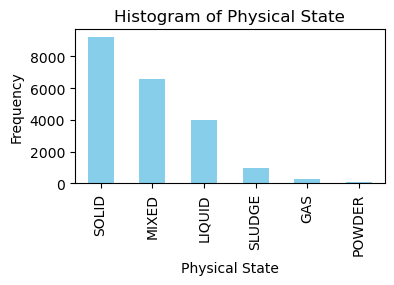

In [26]:
# Remove whitespaces
ewc_trim['Physical State'] = ewc_trim['Physical State'].str.strip()

# Review a few properties
physical_state_unique = ewc_trim['Physical State'].unique()
print(f'There are {len(physical_state_unique)} different forms: {physical_state_unique}')
print(ewc_trim['Physical State'].value_counts())
create_histogram_from_column(ewc_trim, 'Physical State', 4, 2)

The physical state column appears to be clean data with low dimensionality therefore we can apply one hot encoding.

In [27]:
# Redefine params
ps_params = {
    'ps__column_name':'Physical State'
}

# Create a pipeline to build a model
ps_pipe = Pipeline([
    ('ps', OneHotTransformer())
])

ps_pipe.set_params(**ps_params)

# Re-run the pipeline with new estimators
ps_trim = ps_pipe.fit_transform(ewc_trim)
print(ps_trim.iloc[:,-6:].head(2))

OneHotTransformer Start: (21043, 12)
OneHotTransformer: Successfully completed: Physical State
OneHotTransformer: Finished Physical State Shape: (21043, 17)
----------------------------------------------------------------------------------------------------
   Physical State_GAS  Physical State_LIQUID  Physical State_MIXED  \
0                   0                      0                     0   
1                   0                      0                     0   

   Physical State_POWDER  Physical State_SLUDGE  Physical State_SOLID  
0                      0                      0                     1  
1                      0                      0                     1  


## Disposal

The Disposal column contains the names of disposal outlets, in text, for simplicity these are converted into integer values that relate to their index position in an ordered list of unique values. This functionallity is provided by the IndexTransformer class.

In [28]:
# Redefine params
d_params = {
    'classifier__column_name':'Disposal'
}

# Create a pipeline to build a model
d_pipe = Pipeline([
    ('classifier', IndexTransformer())
])

d_pipe.set_params(**d_params)

# Re-run the pipeline with new estimators
d_trim = d_pipe.fit_transform(ps_trim)
print(d_trim.shape)

IndexTransformer Start: Unique Values: 45
IndexTransformer: Successfully completed: Disposal_Index.
IndexTransformer: Finished: Unique Values: 45
----------------------------------------------------------------------------------------------------
(21043, 18)


## Description

This is a short general description of the type of waste, typically less than ten words. This field and the Components field are filled with text, so we need to provide an estimator that can turn text into vectors.

In [29]:
from sklearn.compose import ColumnTransformer

desc_pipe = Pipeline([
    ('count_vectoriser', ColumnVectorizer(max_features_list={'Description':500})),
    ('tfidf_transformer', TfidfTransformer())
])

# A temporary test transformer
dt_pipe = ColumnTransformer([
    ('desc', desc_pipe, ['Description'])
])

# Re-run the pipeline with new estimators
des_trim = dt_pipe.fit_transform(d_trim)
print(des_trim.shape)


ColumnVectoriser: Successfully completed: Description
----------------------------------------------------------------------------------------------------
(21043, 500)


## UN Number

Legal values are NCAD for non hazardous material, or a four digit number that represents a particular category, i.e. non scalar values.

There are 169 unique UN Number values out of 21043 rows


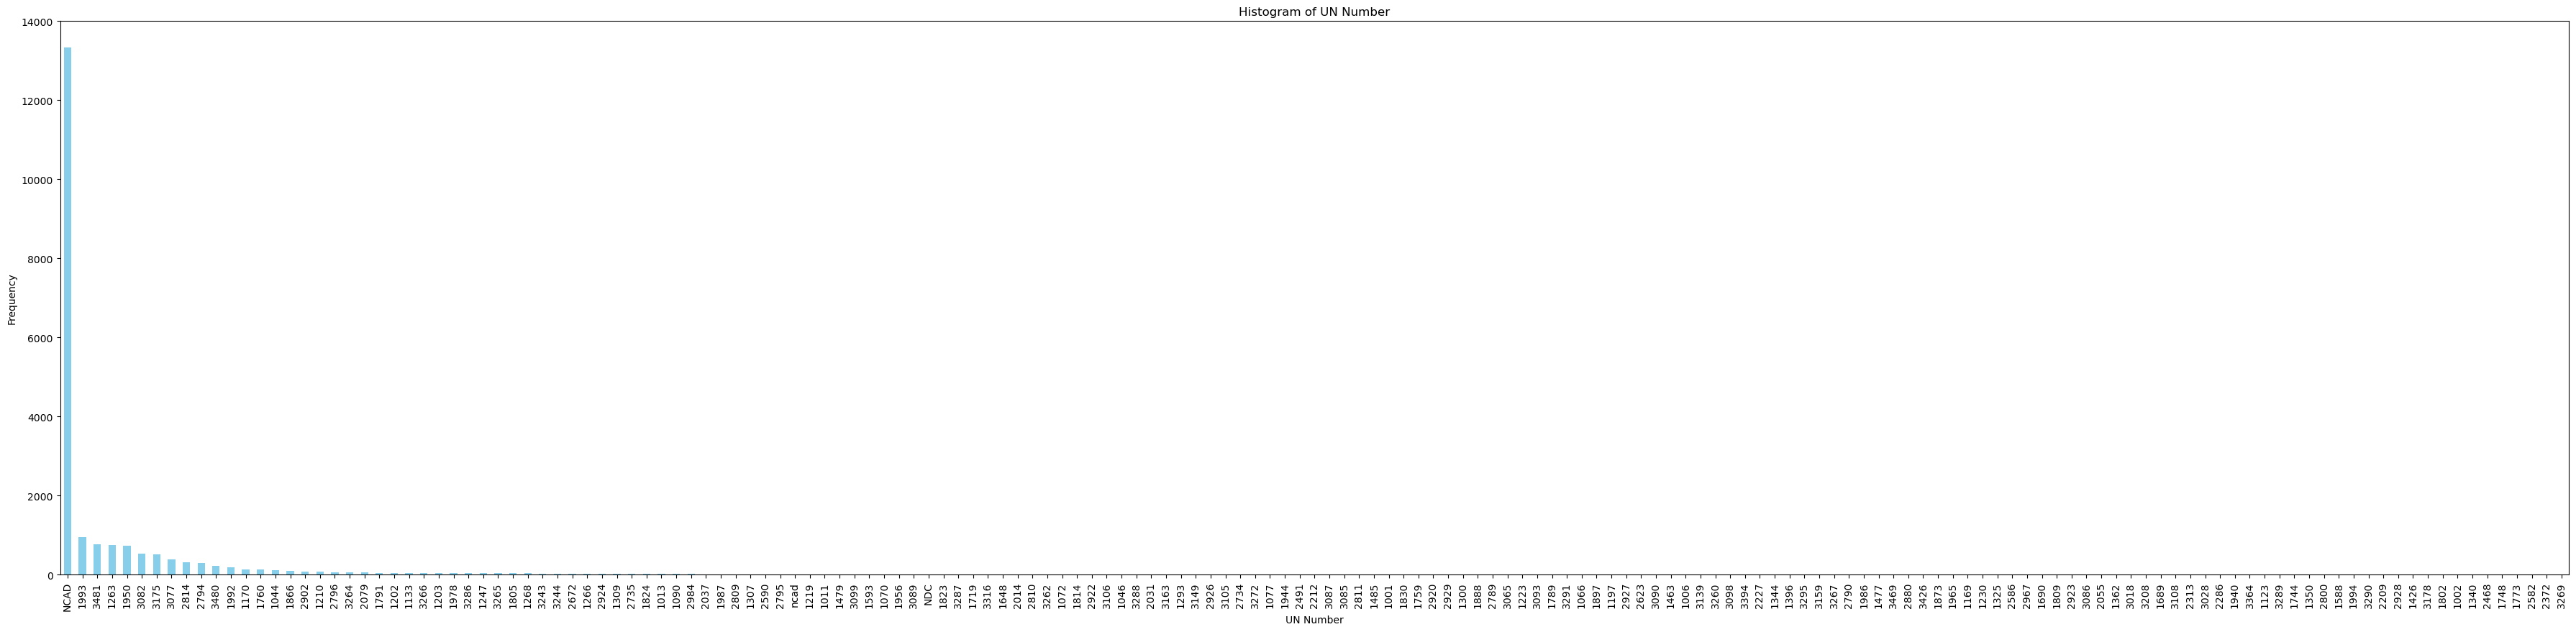

In [30]:
# Find unique values
un_numbers_unique = d_trim['UN Number'].unique()

# View results
print(f'There are {len(un_numbers_unique)} unique UN Number values out of { len(d_trim)} rows' )
create_histogram_from_column(d_trim, 'UN Number', 45, 10)

Similar to EWC codes, UN Numbers are categorical terms with a high number of possibilities, so feature hashing can be employed to reduce the number of dimensions.

In [31]:
# Redefine params
un_params = {
    'un__column_name': 'UN Number',
    'un__num_vec': 4
}

# Create a pipeline to build a model
un_pipe = Pipeline([
    ('un', FeatureHashingTransformer())
])

un_pipe.set_params(**un_params)

# Re-run the pipeline with new estimators
un_trim = un_pipe.fit_transform(d_trim)
print(un_trim.iloc[:,-4:].head(2))
print(un_trim.shape)

FeatureHashingTransformer Start: (21043, 18)
FeatureHashingTransformer: Successfully completed: UN Number
FeatureHashingTransformer: Finished UN Number Shape: (21043, 21)
----------------------------------------------------------------------------------------------------
   UN Number_0  UN Number_1  UN Number_2  UN Number_3
0          0.0          3.0          6.0          3.0
1          0.0          3.0          6.0          3.0
(21043, 21)


## Components and Concentrations

A list of component / concentration pairs, or if this is too complex "As list", or if non hazardous "Nil Hazardous Components".

This field has chemical names and concentrations which to a human reader with some knowledge of chemistry are easy to comprehend, to capture the same level of understanding at machine learning level though will be difficult. Not withstanding the additional complication of free text entry and typographical errors, there are several naming conventions for chemical names, new/old and very old, european, american... and so on. We also find "as list" and "nil hazardous components" in this field which are legitimate terms within the boundaries of waste description, but their level of abstractness circumnavigates any methodology relating to the recognition of chemical entities. Instead we shall consider a broader scope, that more closely matching the capture of meaning or semantics.

This field is rich in chemical nomenclature that form common word fragments. For example chemicals that contain one of the halogen elements, all have four character fragments such as fluo, chlo, brom, Iodo. Alkyl alcohols all contain a common term for the length of the carbon chain and end with 'anol', e.g. eth-anol, meth-anol, prop-anol. etc. Perhaps there is scope to consider fragmenting the words in this column and hoping that the most common chemical fragments will float to the top in a frequency distribution, but this asks the question of how to fragment and how many features would this create, for now we will consider only whole words, misspellings and all.

The simplest approach is the adoption of a 'bag of words', without necessarily concerning ourselves with word order or relationships between them. If we treat all words in the column as being the corpus, or bag, then we can assign a position or vector for each word, then averaging these provides us with a vector for the entire sentence. The learning aspect then involves estabilishing the proximity of similar vectors and associating these with a label.


In [32]:
# Create a pipeline to build a model
comp_pipe = Pipeline([
    ('count_vectoriser', ColumnVectorizer(max_features_list={'Components and Concentrations':1000})),
    ('tfidf_transformer', TfidfTransformer())
])

# A temporary test transformer
cc_ct = ColumnTransformer([
    ('comp', comp_pipe, ['Components and Concentrations'])
])

# Re-run the pipeline with new estimators
cc_trim = cc_ct.fit_transform(un_trim)
print(cc_trim)
print(cc_trim.shape)

ColumnVectoriser: Successfully completed: Components and Concentrations
----------------------------------------------------------------------------------------------------
  (0, 641)	0.701814867017563
  (0, 195)	0.7123593843230539
  (1, 641)	0.701814867017563
  (1, 195)	0.7123593843230539
  (2, 980)	0.31837145058159677
  (2, 931)	0.539490842335214
  (2, 662)	0.25334577650328266
  (2, 615)	0.2792382435203103
  (2, 311)	0.6822251617865261
  (3, 865)	0.7053666645433979
  (3, 406)	0.7088426260820674
  (4, 862)	0.42356517268567756
  (4, 676)	0.7822444816991628
  (4, 543)	0.17111008102012124
  (4, 81)	0.42356517268567756
  (5, 755)	0.3885315128811073
  (5, 638)	0.453927200423954
  (5, 462)	0.3561173598100935
  (5, 196)	0.49186242072704395
  (5, 143)	0.5236842038213584
  (6, 996)	0.40080102210589863
  (6, 923)	0.19119916745456983
  (6, 463)	0.2625299498283628
  (6, 381)	0.28513668296629524
  (6, 373)	0.2914801513657153
  :	:
  (21035, 78)	0.42629631832211495
  (21036, 980)	0.5634547299586701

## Hazard Codes

A list of codes relating to hazardous properties, from HP1 to HP15.

Each HP code can appear once in the list, furthermore these are categorical terms so we can adopt one hot encoding.

In [33]:
# A list of all legitimate values in the Hazard Codes column
hp_codes = ['HP1','HP2','HP3','HP4','HP5','HP6','HP7','HP8','HP9','HP10','HP11','HP12','HP13','HP14','HP15', 'NC','POP']
# Redefine params
hp_params = {
    'hp__column_name': 'Hazard Codes',
    'hp__tokens': hp_codes
}

# Create a pipeline to build a model
hp_pipe = Pipeline([
    ('hp', OneHotTokenTransformer())
])

hp_pipe.set_params(**hp_params)

# Re-run the pipeline with new estimators
hp_trim = hp_pipe.fit_transform(d_trim)
print(hp_trim.iloc[:, -1 * len(hp_codes):].head(2))
print(hp_trim.shape)

OneHotTokenTransformer Start: (21043, 18)
OneHotTokenTransformer: Successfully completed: Hazard Codes
OneHotTokenTransformer: Finished Hazard Codes Shape: (21043, 34)
----------------------------------------------------------------------------------------------------
   HP1  HP2  HP3  HP4  HP5  HP6  HP7  HP8  HP9  HP10  HP11  HP12  HP13  HP14  \
0    0    0    0    0    0    0    0    0    0     0     0     0     0     0   
1    0    0    0    0    0    0    0    0    0     0     0     0     0     0   

   HP15  NC  POP  
0     0   0    0  
1     0   0    0  
(21043, 34)


# Combining Everything

Having looked at all feature columns and tested them as individual segments, we can now combine them all into one pipeline.

In [34]:
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score

df_raw = pd.read_csv("data/raw3.csv")

# Tidy up in a pre processing pipeline:
# Trim rows and columns, turn text labels into numbers by indexing them, fill in empty values.

pre_pipe = Pipeline([
    ('row_trimmer', rt_pipe),
    ('column_trimmer', ct_pipe),
    ('replace_values', rv_pipe),
    ('text_cleaner', tc_pipe),
    ('index_transformer', IndexTransformer(column_name='Disposal'))
])

df_pre = pre_pipe.fit_transform(df_raw)

outlets = pd.DataFrame({'Disposal': df_pre['Disposal'].unique()})
outlets = outlets.sort_values(by='Disposal').reset_index(drop=True)

print(df_pre.isnull().sum())
print(f'-'*100)
print(df_pre.Disposal.value_counts())
print(f'-'*100)
print(df_pre.Disposal.tail(5))
print(f'-'*100)
print(df_pre.shape)


RowTrimmer: Out of 47 outlets, 2 appear less than 5 times. 3 rows have been trimmed.
RowTrimmer: (21043, 42)
ColumnTrimmer: After trimming 7 columns remain.
Description                      object
Components and Concentrations    object
Hazard Codes                     object
UN Number                        object
EWC                              object
Disposal                         object
Physical State                   object
dtype: object
ColumnTrimmer: (21043, 7)
TextCleaner: Successfully completed: ['Description', 'Components and Concentrations', 'Hazard Codes', 'UN Number', 'EWC', 'Disposal', 'Physical State']
TextCleaner: Finished Shape: (21043, 7)
----------------------------------------------------------------------------------------------------
IndexTransformer Start: Unique Values: 45
IndexTransformer: Successfully completed: Disposal_Index.
IndexTransformer: Finished: Unique Values: 45
------------------------------------------------------------------------------------

## Test Train Split with Stratified Folds

In [35]:
# Define the training set, typically called X
X = df_pre.drop(['Disposal_Index'], axis=1)
print(X.shape)

# Define a column of labels
y = df_pre['Disposal_Index']
print(y.shape)

# Create randomised folds that preserve the distribution of classes in each fold.
# Initialize the StratifiedKFold
skf = StratifiedKFold(n_splits=k_folds, random_state=42, shuffle=True)

try:
    # Split the data into training and testing sets using the stratified k-fold
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print("Training set classes distribution:")
    print(y_train.value_counts())

    print("Testing set classes distribution:")
    print(y_test.value_counts())
except KeyError as e:
    print("KeyError:", e)


(21043, 7)
(21043,)
Training set classes distribution:
42    2136
27    1553
13    1486
7     1368
28    1326
18    1151
21     766
40     691
39     525
34     523
19     512
5      393
6      368
44     358
17     339
2      323
11     299
37     286
24     281
25     249
9      232
20     228
31     188
14     178
15     141
0      131
12     124
16      86
32      67
22      66
41      62
30      58
43      47
4       45
3       43
36      39
23      37
29      32
8       27
38      18
10      17
1       14
35      12
33       5
26       5
Name: Disposal_Index, dtype: int64
Testing set classes distribution:
42    533
27    389
13    371
7     342
28    331
18    288
21    192
40    173
39    132
34    131
19    127
5      98
6      92
44     90
17     85
2      81
11     75
37     72
24     70
25     62
20     58
9      58
31     47
14     44
15     35
0      33
12     31
16     22
22     17
41     16
32     16
30     15
43     11
4      11
23     10
3      10
36      9
29      8
8

## Preprocessor

In [36]:
# Define the columns to remove numbers from
preprocessor = ColumnTransformer([
    ('desc', desc_pipe, ['Description']),
    ('comp', comp_pipe, ['Components and Concentrations']),
    ('ewc', ewc_pipe,['EWC']),
    ('phy', ps_pipe,['Physical State']),    
    ('unn', un_pipe,['UN Number']),
    ('haz', hp_pipe,['Hazard Codes'])
],remainder='drop')

# Classification with RandomForestClassifier

In [37]:
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

cv_params = {
    'classifier__n_estimators': [700, 750, 800],
    'classifier__max_depth': [None, 1, 10],
    'classifier__min_samples_split': [2, 10],
    'classifier__min_samples_leaf': [2, 10],
    'classifier__random_state': [2, 42]
}

## Hyperparameter Tuning with RandomizedSearchCV

In [38]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import joblib

random_search = RandomizedSearchCV(pipe, cv_params, cv=skf, scoring='roc_auc_ovr', n_iter=10, n_jobs=-1)
random_search.fit(X_train,y_train)

results = pd.DataFrame(random_search.cv_results_)[['params','mean_test_score','rank_test_score']]
results.sort_values('rank_test_score')

best_model = random_search.best_estimator_
print(results)
print(random_search.best_params_)

## Cross Validation

In [ ]:

cross_val_score(best_model, X_train, y_train, cv=skf, scoring='roc_auc_ovr', error_score="raise", n_jobs=-1).mean()


## Cross Validation with Feature Selection

In [ ]:
from sklearn.feature_selection import SelectPercentile, chi2
selection = SelectPercentile(chi2, percentile=50)

selector_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', selection),
    ('classifier', RandomForestClassifier())
])

selector_pipe.set_params(**random_search.best_params_)

cross_val_score(selector_pipe, X_train, y_train, cv=skf, scoring='roc_auc_ovr', error_score="raise", n_jobs=-1).mean()

## RandomizedForest Results

### Accuracy

In [ ]:
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)

### Confusion Matrix

In [ ]:
# Turn Disposal_Index back into Disposal names
r_test = [outlets.loc[t, 'Disposal'] for t in y_test]
r_pred = [outlets.loc[t, 'Disposal'] for t in y_pred]
labels = sorted(set(r_test))
labelsy = sorted(set(r_pred))
print(len(labels))
cm = confusion_matrix(r_test, r_pred)
print(cm.shape) 

df_cm = pd.DataFrame(cm, index=labels, columns=labels)
# Plot a confusion matrix
sn.set(font_scale=0.75)
a4_dims = (16, 10)
fig, ax = plt.subplots(figsize=a4_dims)
ax.set_title("Confusion Matrix True vs Predicted Outlet")
hm = sn.heatmap(df_cm, annot=True, cmap="Dark2_r", cbar_kws={'label': 'Count'})  
plt.show()

### Classification Report

In [ ]:
cr = classification_report(r_test, r_pred)    
print(cr)

# Classification with XGBoost

In [ ]:
from xgboost import XGBClassifier
import xgboost as xgb

## Hyperparameter Tuning with Hyperopt

In [ ]:
# define a search space
from hyperopt import hp, fmin, tpe, Trials
from sklearn.metrics import roc_auc_score

# Define the search space
space = { 
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 1.0),
    'max_depth': hp.quniform('max_depth', 3, 20, 1),    
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.01, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.01, 1.0),
    'gamma': hp.uniform('gamma', 0.0, 0.5)
}

# Define the objective function for XGBoost classifier
def objective(params):
    # Extract hyperparameters
    n_estimators = params['n_estimators']
    learning_rate = params['learning_rate']
    max_depth = params['max_depth']
    subsample = params['subsample']
    colsample_bytree = params['colsample_bytree']
    colsample_bylevel = params['colsample_bylevel']
    reg_lambda = params['reg_lambda']
    reg_alpha = params['reg_alpha']
    gamma = params['gamma']
    
    # Define XGBoost parameters
    xgb_params = { 
        'objective': 'multi:softmax',
        'num_class': 45,  # Number of classes
        'eval_metric': 'mlogloss',
        'predict_leaf': True,
        'learning_rate': learning_rate,
        'max_depth': int(max_depth),
        'n_estimators': int(n_estimators),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'colsample_bylevel':colsample_bylevel,
        'reg_lambda':reg_lambda,
        'reg_alpha':reg_alpha,
        'gamma': gamma,
        'random_state':2,
        'verbosity': 0,
        'n_jobs': -1
    }
    
    # Preprocessing pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor), 
        ('clf', XGBClassifier(**xgb_params))
    ])

    # Fit the model
    model = pipeline.fit(X_train, y_train)

    # Predict probabilities on the validation set
    y_proba = model.predict_proba(X_test)

    # Calculate ROC AUC score, one vs rest
    roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
    
    # Calculate accuracy
    y_pred = model.predict(X_test)    
    accuracy = accuracy_score(y_test, y_pred)

    print('-'*100)
    print(f'loss: {-roc_auc}')
    print(f'accuracy: {-accuracy}')
    print(f'learning_rate:{learning_rate}')
    print(f'max_depth:{max_depth}')
    print(f'n_estimators:{n_estimators}')
    print(f'subsample:{subsample}')
    print(f'colsample_bytree:{colsample_bytree}')
    print(f'colsample_bylevel:{colsample_bylevel}')
    print(f'reg_lambda:{reg_lambda}')
    print(f'reg_alpha:{reg_alpha}')
    print(f'gamma:{gamma}')
    print('-'*100) 

    return {
        'loss': -roc_auc,
        'accuracy': accuracy,
        'learning_rate': learning_rate,
        'max_depth': int(max_depth),
        'n_estimators': int(n_estimators),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'colsample_bylevel': colsample_bylevel,
        'reg_lambda': reg_lambda,
        'reg_alpha': reg_alpha,
        'gamma': gamma,
        'status': 'ok'
    }  # Minimize negative accuracy

# Perform hyperparameter optimization
trials = Trials()
best_xgb_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=30, trials=trials)

print("Best hyperparameters:", best_xgb_params)


### View Results of Tuning

In [ ]:
df_results = pd.DataFrame(trials.results)

def ScatterPlot(x, y, title):
    plt.scatter(x,y,marker='o')
    plt.xlabel(title)
    plt.ylabel('Loss')
    plt.title('Hyperopt XGBoost Trials - ' + title)
    plt.show()
    
y_results = df_results['loss'].values

# Plot the loss values
plt.plot(trials.losses())
plt.xlabel('Trial')
plt.ylabel('Loss')
plt.title('Hyperopt XGBoost Trials')
plt.show()

ScatterPlot(df_results['learning_rate'].values, y_results, 'Learning Rate')
ScatterPlot(df_results['n_estimators'].values, y_results, 'Num Estimators')
ScatterPlot(df_results['max_depth'].values, y_results, 'Max Depth')
ScatterPlot(df_results['subsample'].values, y_results, 'Subsample')
ScatterPlot(df_results['colsample_bytree'].values, y_results, 'colsample_bytree')

## XGBoost Pipeline with Tuned Parameters

In [ ]:
params = {
    'objective': 'multi:softmax',
    'num_class': 45,  # Number of classes
    'eval_metric': 'mlogloss',
    'predict_leaf': True,
    'colsample_bylevel': 0.8068013524551562, 
    'colsample_bytree': 0.8500944947381192, 
    'learning_rate': 0.03408153269406498, 
    'max_depth': int(14), 
    'n_estimators': int(410),
    'reg_alpha': 0.19165050933044292, 
    'reg_lambda': 0.26137263103306296, 
    'subsample': 0.5005635117075657,
    'gamma': 0.25
}

params = best_xgb_params

xgb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(**params))
])

### Cross Validation with Xgboost

In [ ]:

cross_val_score(xgb_pipe, X_train, y_train, cv=skf, scoring='roc_auc_ovr', error_score="raise", n_jobs=-1).mean()


### Fit an XGBoost model with Best Parameters

In [ ]:

# Fit the model with early stopping
xgb_model = xgb_pipe.fit(X_train, y_train)

# Get the predicted probabilities for each class
xgb_y_proba = xgb_model.predict_proba(X_test)

# Calculate ROC AUC score
xgb_roc_auc = roc_auc_score(y_test, xgb_y_proba, multi_class='ovr')

xgb_y_pred = xgb_pipe.predict(X_test)

# Calculate accuracy
xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
print('----------------------------------')
print(f'loss: {-xgb_roc_auc}')
print(f'accuracy: {-xgb_accuracy}')
print('----------------------------------')


### Predict the Top Three 

In [ ]:

# Extract the top 3 classes based on probabilities for each row
top_3_classes = np.flip(np.argsort(xgb_y_proba, axis=1), axis=1)[:, :3]

# Print the top 3 predicted classes and their respective probabilities
for i, row_top_3 in enumerate(top_3_classes):
    desc = X_test.iloc[i]['Description'].ljust(50)
    print(f"Row {i+1} - {desc}")    
    for j, class_idx in enumerate(row_top_3):        
        class_label = pipe.classes_[class_idx]
        class_Id = f'{class_label:0>{2}}'
        name = outlets.iloc[class_label]['Disposal'].ljust(20)
        probability = xgb_y_proba[i][class_idx]
        print(f"{j+1}: {class_Id} {name} {probability}")
    print('-'*100)

## Training a Model with Tuned Parameters

In [ ]:

best = {
    'objective': 'multi:softmax',
    'num_class': 45,  # Number of classes
    'eval_metric': 'mlogloss',
    'predict_leaf': True,
    'colsample_bylevel': 0.8055381025833828, 
    'colsample_bytree': 0.6149087935503202, 
    'learning_rate': 0.022372243616914922, 
    'max_depth': 14, 
    'n_estimators': 754, 
    'reg_alpha': 0.754124531179756, 
    'reg_lambda': 0.6811072757618393, 
    'subsample': 0.5010578267429385
}

best = trials.best_trial['result']


# Preprocessing pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('clf', XGBClassifier(**best))
])

# Fit the model with early stopping
pipeline.fit(X_train, y_train)


In [ ]:

# Predict probabilities on the validation set
y_proba = pipeline.predict_proba(X_test)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')

y_pred = pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('----------------------------------')
print(f'loss: {-roc_auc}')
print(f'accuracy: {-accuracy}')
print('----------------------------------')

In [ ]:
# Turn Disposal_Index back into Disposal names
r_test = [outlets.loc[t, 'Disposal'] for t in y_test]
r_pred = [outlets.loc[t, 'Disposal'] for t in y_pred]
labels = sorted(set(r_test))
labelsy = sorted(set(r_pred))
print(len(labels))
cm = confusion_matrix(r_test, r_pred)
print(cm.shape) 

df_cm = pd.DataFrame(cm, index=labels, columns=labels)
# Plot a confusion matrix
sn.set(font_scale=0.75)
a4_dims = (16, 10)
fig, ax = plt.subplots(figsize=a4_dims)
ax.set_title("Confusion Matrix True vs Predicted Outlet")
hm = sn.heatmap(df_cm, annot=True, cmap="viridis", cbar_kws={'label': 'Count'})  
plt.show()

In [ ]:
cr = classification_report(r_test, r_pred)    
print(cr)

In [ ]:

# Define XGBoost parameters
xgb_params = {
    'objective': 'multi:softmax',
    'num_class': 45,  # Number of classes
    'eval_metric': 'mlogloss',
    'predict_leaf': True,
    'learning_rate': best['learning_rate'],
    'max_depth': int(best['max_depth']),
    'n_estimators': int(best['n_estimators']),
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'colsample_bylevel': best['colsample_bylevel'],
    'reg_alpha':best['reg_alpha'],
    'reg_lambda':best['reg_lambda'],
    'verbosity': 0
}
xt = preprocessor.transform(X_train)
ts = preprocessor.transform(X_test)


In [ ]:

dtrain = xgb.DMatrix(xt, label=y_train)
dtest = xgb.DMatrix(ts, label=y_test)  # Assuming y_test is available for evaluation

eval_set = [(dtrain, 'train'),(dtest, 'eval')]  # Specify the validation dataset

eval_results = {}
xgb_model = xgb.train(xgb_params, dtrain, early_stopping_rounds=20, num_boost_round=1000, evals=eval_set, evals_result=eval_results)


In [ ]:
train_error = eval_results['train']['merror']
val_error = eval_results['eval']['merror']

plt.plot(train_error, label='Training Error')
plt.plot(val_error, label='Validation Error')
plt.xlabel('Boosting Round')
plt.ylabel('Multiclass Error')
plt.legend()
plt.show()

In [ ]:
import joblib
# Save the trained model to a file
#joblib.dump(xgb_model, 'c:/users/user/desktop/models/xgboost_trained_model.pkl')

## Predictions with XGBoost Model

In [ ]:
# make predictions on test data
y_pred = xgb_model.predict(dtest)
print(y_test.head())


In [ ]:
# Predict probabilities
print(xgb_model.best_ntree_limit)
print(xgb_model.best_iteration)
print(xgb_model.best_score)

## Results Analysis

### Accuracy

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

### Classification Report

In [ ]:
# Print classification report
print(classification_report(y_test, y_pred))

### Feature Importance

In [ ]:
# Feature Importance
from xgboost import plot_importance

# Plot feature importance for the top 30 features
plot_importance(xgb_model, max_num_features=100, show_values=True)
plt.rcParams['figure.figsize'] = [20,25]
plt.show()

### Confusion Matrix

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# Turn Disposal_Index back into Disposal names
r_test = [outlets.loc[t, 'Disposal'] for t in y_test]
labels = sorted(set(r_test))

df_cm = pd.DataFrame(cm, index=labels, columns=labels)
# Plot a confusion matrix
sn.set_theme(font_scale=0.75)
a4_dims = (16, 10)
fig, ax = plt.subplots(figsize=a4_dims)
ax.set_title("Confusion Matrix True vs Predicted Outlet")
hm = sn.heatmap(df_cm, annot=True, cmap="coolwarm", cbar_kws={'label': 'Count'})  
plt.show()